## MODULE 1: 

## Import standard Libraries and packages

In [112]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from datetime import date

## Project Objectives and Dataset Source

* **Objective:** This is the first module in a series of the KPMG Virtual Internship Challenge that includes 3 modules in total. This module #1 is intended to examine the quality of the customers dataset and performa data wrangling in preparation for the development of a ML model in Module 2. In addition, a visualization dashboard will also be created from the cleaned datasets using PowerBI.
* **Analytics Type:** Data Quality Analysis and Analytical Dashboard Creation.
* **Data Type:** Structured data (Nemerical and Categorical), time-series. Since it's a structured dataset, the clean dataset can be stored in a SQL database such as SQL Elephant or PostgreSQL.
* **Visualization Method:** Python libraries such as MatplotLib, Seaborn. In addition, a dashboard will also be created using Power BI.
* **Data Source:** Dataset was provided by KPMN's client, Sprocket Central Pty Ltd. 
* **Dataset includes:**
        * Customer Demographic
        * Customer Addresses
        * Transactions data in the past 3 months

# Data Quality Analysis includes:

* Check data accuracy: if values are close to true values.
* Check data completeness: fill nan values with values that make sense. Drop rows if neccessary.
* Check data consistency: check if values contradict to normally observed trends.
* Check data currency: check if data are up to date.
* Check data relevancy: drop columns or values that do not make any differences in the analysis or ML model development.
* Validate data: check if data are within allowable ranges of values, and check for outliers. Ex: someone's age cannot be over 200.
* Check for duplicates: remove duplicates to avoid double dipping in the ML model.


### Data Loading

In [113]:
# Load excel file, which includes multiple worksheets
xls = pd.ExcelFile('KPMG_VI_New_raw_data_update_final.xlsx')

In [114]:
# Assign each worksheet to a variable
CustomerDemographic = pd.read_excel(xls, 'CustomerDemographic', skiprows=[0])
CustomerAddress = pd.read_excel(xls, 'CustomerAddress', skiprows=[0])
Transactions = pd.read_excel(xls, 'Transactions', skiprows=[0])
NewCustomerList = pd.read_excel(xls, 'NewCustomerList', skiprows=[0])

#**DATASET 1: CUSTOMER DEMOGRAPHIC**

In [115]:
CustomerDemographic.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


In [116]:
# Calcualte Age
now = pd.to_datetime('now')
CustomerDemographic['Age'] = (now.year - CustomerDemographic['DOB'].dt.year) - ((now.month - CustomerDemographic['DOB'].dt.month) < 0)

# Drop DOB
CustomerDemographic.pop('DOB')
CustomerDemographic.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,Age
0,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0,67.0
1,2,Eli,Bockman,Male,81,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0,40.0
2,3,Arlin,Dearle,Male,61,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0,67.0
3,4,Talbot,NaN,Male,33,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0,59.0
4,5,Sheila-kathryn,Calton,Female,56,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0,44.0


## Data Quality Analysis

In [117]:
# Check number of rows and columns
CustomerDemographic.shape

(4000, 13)

In [118]:
# Data types
CustomerDemographic.dtypes

customer_id                              int64
first_name                              object
last_name                               object
gender                                  object
past_3_years_bike_related_purchases      int64
job_title                               object
job_industry_category                   object
wealth_segment                          object
deceased_indicator                      object
default                                 object
owns_car                                object
tenure                                 float64
Age                                    float64
dtype: object

**1. Check data accuracy**

In [119]:
# Check if customer_id values are all unique. Each customer should have only one unique customer_id
customerID_duplicated = CustomerDemographic['customer_id'].duplicated().any()
customerID_duplicated

False

**2. Check data completeness**

In [120]:
# Rows with missing values count and percentage
empty_rows_count = CustomerDemographic.isnull().sum()
empty_rows_perc = empty_rows_count/len(CustomerDemographic)*100

null_values_perc = pd.DataFrame(empty_rows_count, columns=['Null_rows_count'])
null_values_perc['Null_rows_percentage'] = empty_rows_perc
null_values_perc


,Null_rows_count,Null_rows_percentage
customer_id,0,0.000
first_name,0,0.000
last_name,125,3.125
gender,0,0.000
past_3_years_bike_related_purchases,0,0.000
job_title,506,12.650
job_industry_category,656,16.400
wealth_segment,0,0.000
deceased_indicator,0,0.000
default,302,7.550


- last_name column has 125 null values (~3%). However, this will not impact the model training in the next module since we can use customer_id as unique key to identify that particular customer.
- job_title and job_industry_category are 2 important features of the dataset. We will keep these rows and replace null values with 'Unknown'.
- default column has 302 null values (7.5%) but it is a redundant column and will be dropped.
- tenure column has 87 null values (~2%) and will be replaced with the minumum value of 1.
- Age column has 87 null values (~2%). Since only 2% of data is missing, we can Fill these null values with mode, most frequent appearing values.

**3. Check data consistency**

In [121]:
# Check unique values for each column
CustomerDemographic["gender"].unique()

array(['F', 'Male', 'Female', 'U', 'Femal', 'M'], dtype=object)

In [122]:
CustomerDemographic["deceased_indicator"].unique()

array(['N', 'Y'], dtype=object)

In [123]:
# Check unique values for each column
CustomerDemographic["deceased_indicator"].value_counts()

N    3998
Y       2
Name: deceased_indicator, dtype: int64

In [124]:
CustomerDemographic["job_industry_category"].unique()

array(['Health', 'Financial Services', 'Property', 'IT', nan, 'Retail',
       'Argiculture', 'Manufacturing', 'Telecommunications',
       'Entertainment'], dtype=object)

In [125]:
CustomerDemographic["wealth_segment"].unique()

array(['Mass Customer', 'Affluent Customer', 'High Net Worth'],
      dtype=object)

In [126]:
CustomerDemographic["owns_car"].unique()

array(['Yes', 'No'], dtype=object)

- Column gender contains input that can be simplified to only "Female", "Male", and "Unknown"
- The majority of customers are alive and column "deceased_indicator" does not add any value to the analysis or ML model. It can be dropped.
- Column job_industry_category contain nan values that can be filled with "Unknown"

**4. Check data currency**

- Customers information such as name, address, job title, etc. can be updated if there are any changes.

**5. Check data relevancy**

- Column 'default' does not have meaning and thus does not add any value to the analysis.

**6. Validate data and check for outliers**

In [127]:
# Summary statistics for columns with datatypes integer and float
CustomerDemographic.describe(include=['int64', 'float64'])

,customer_id,past_3_years_bike_related_purchases,tenure,Age
count,4000.000000,4000.000000,3913.000000,3913.000000
mean,2000.500000,48.890000,10.657041,43.462050
std,1154.844867,28.715005,5.660146,12.801164
min,1.000000,0.000000,1.000000,19.000000
25%,1000.750000,24.000000,6.000000,34.000000
50%,2000.500000,48.000000,11.000000,43.000000
75%,3000.250000,73.000000,15.000000,53.000000
max,4000.000000,99.000000,22.000000,177.000000


- Customers Age max is 177. This is impossible as the world's oldest person record is about 122 years old. This is a wrong data entry. Replace values larger than 122 by 122.

**7. Check for duplicates**

In [128]:
# Count number of duplicates for each column
CustomerDemographic.duplicated().sum()

0

## Data Cleaning

**Fill in nan values as suggested above**

In [129]:
# fill nan values in column last_name with 'Unknown'
CustomerDemographic["last_name"].fillna('Unknown', inplace=True)

In [130]:
# fill nan values in DOB column with mode
CustomerDemographic['Age'].fillna(CustomerDemographic['Age'].mode()[0], inplace=True)

In [131]:
# fill nan values in job_title and job_industry_category columns with 'Unknown'
CustomerDemographic["job_title"].fillna('Unknown', inplace=True)
CustomerDemographic["job_industry_category"].fillna('Unknown', inplace=True)

In [132]:
# fill nan values in column tenure with minimum value of 1 to be in the conservative side
CustomerDemographic['tenure'].fillna(CustomerDemographic['tenure'].min(), inplace=True)

In [133]:
# Check null values after fillna
CustomerDemographic.isnull().sum()

customer_id                              0
first_name                               0
last_name                                0
gender                                   0
past_3_years_bike_related_purchases      0
job_title                                0
job_industry_category                    0
wealth_segment                           0
deceased_indicator                       0
default                                302
owns_car                                 0
tenure                                   0
Age                                      0
dtype: int64

**Replace misstyped data as suggested above**

In [134]:
# Simplify data entry by replacing F and Femal with "Female" and M with "Male"
CustomerDemographic["gender"].replace(dict.fromkeys(['F','Femal'], 'Female'), inplace=True)
CustomerDemographic["gender"].replace(dict.fromkeys(['M'], 'Male'), inplace=True)
CustomerDemographic["gender"].replace(dict.fromkeys(['U'], 'Unknown'), inplace=True)
CustomerDemographic["gender"].unique()

array(['Female', 'Male', 'Unknown'], dtype=object)

In [135]:
# Replace Ages > 122 with 122
CustomerDemographic['Age'].values[CustomerDemographic['Age'].values >= 122] = 122

In [136]:
# Check if max age is 122
CustomerDemographic['Age'].max()

122.0

**Drop irrelevant columns**

In [137]:
# drop column 'default' as it does not add any value to the analysis
CustomerDemographic.drop('default', axis='columns', inplace=True)

In [138]:
# drop column 'deceased_indicator' as almost all customers are still alive
CustomerDemographic.drop('deceased_indicator', axis='columns', inplace=True)

In [139]:
# Save clean dataset
CustomerDemographic.to_csv("CustomerDemographic.csv")

## Preliminary Analysis

In [140]:
CustomerDemographic.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,Age
0,1,Laraine,Medendorp,Female,93,Executive Secretary,Health,Mass Customer,Yes,11.0,67.0
1,2,Eli,Bockman,Male,81,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,40.0
2,3,Arlin,Dearle,Male,61,Recruiting Manager,Property,Mass Customer,Yes,15.0,67.0
3,4,Talbot,Unknown,Male,33,Unknown,IT,Mass Customer,No,7.0,59.0
4,5,Sheila-kathryn,Calton,Female,56,Senior Editor,Unknown,Affluent Customer,Yes,8.0,44.0


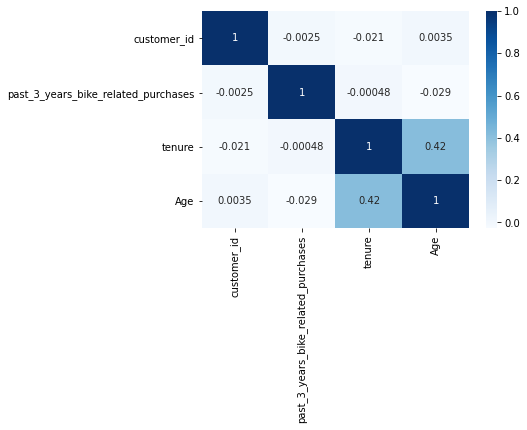

In [141]:
corr = CustomerDemographic.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

- There's a slight positive correlation between Age and tenure. This means older people has longer subscription time.
- There is almost no correlation between Age and pas_3_years_bike_related_purchases.

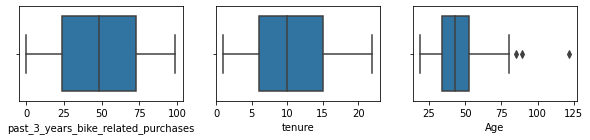

In [142]:
# Check for outliers
i=1
columns = ['past_3_years_bike_related_purchases', 'tenure', 'Age']
plt.figure(figsize=(10,8))
for j in columns:
    plt.subplot(4,3,i)
    sns.boxplot(data=CustomerDemographic,x=CustomerDemographic[j])
    i+=1

- Only Age column has outliers but still within allowable limits.

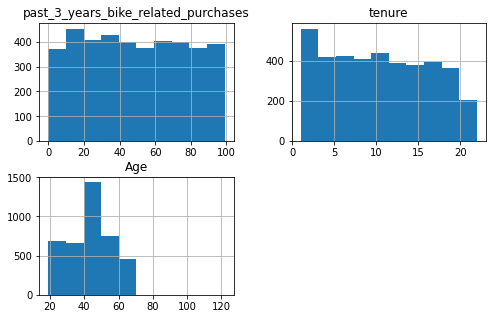

In [143]:
data = CustomerDemographic[['past_3_years_bike_related_purchases', 'tenure', 'Age']]
data.hist(figsize=(8,5))
plt.show()

- None of the variables has a normal distribution.

In [144]:
# Calculate percentage of customers by gender
data_gender =pd.DataFrame((CustomerDemographic.groupby(['gender'])['customer_id'].count())/len(CustomerDemographic)*100)
data_gender = data_gender.reset_index()
data_gender

,gender,customer_id
0,Female,50.975
1,Male,46.825
2,Unknown,2.200


Text(0, 0.5, 'Percentage (%)')

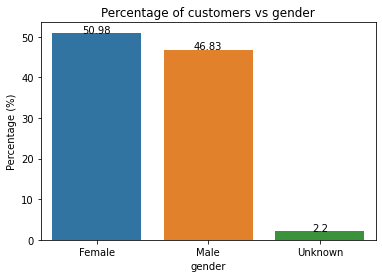

In [145]:
# Create bar plot
visual = sns.barplot(x="gender", y="customer_id", data=data_gender )

for index, row in data_gender.iterrows():
    visual.text(row.name,row.customer_id, round(row.customer_id,2), color='black', ha="center")
plt.title('Percentage of customers vs gender')
plt.ylabel('Percentage (%)')

- The number of female customers is only slightly higher than the male customers.

In [146]:
# Calculate percentage of customers by job_industry_category
data_industry = pd.DataFrame((CustomerDemographic.groupby(['job_industry_category'])['customer_id'].count())/len(CustomerDemographic)*100)
data_industry = data_industry.sort_values(by=['customer_id'], ascending=False)
data_industry = data_industry.reset_index()
data_industry

,job_industry_category,customer_id
0,Manufacturing,19.975
1,Financial Services,19.350
2,Unknown,16.400
3,Health,15.050
4,Retail,8.950
5,Property,6.675
6,IT,5.575
7,Entertainment,3.400
8,Argiculture,2.825
9,Telecommunications,1.800


Text(0, 0.5, 'Percentage (%)')

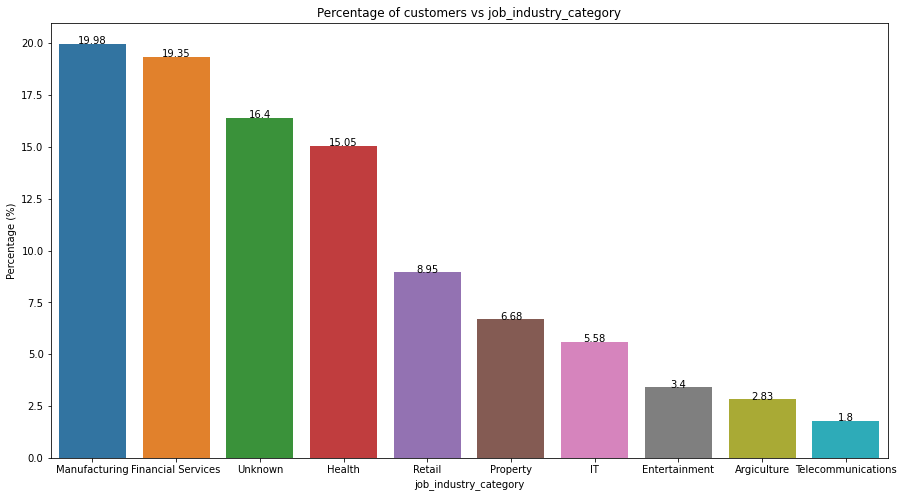

In [147]:
# Create bar plot
plt.figure(figsize=(15,8))
visual = sns.barplot(x="job_industry_category", y="customer_id", data=data_industry )

for index, row in data_industry.iterrows():
    visual.text(row.name,row.customer_id, round(row.customer_id,2), color='black', ha="center")
plt.title('Percentage of customers vs job_industry_category')
plt.ylabel('Percentage (%)')

- The top 3 industries that the customers work in are Manufacturing, Financial Services, and Health. 

In [148]:
# Calculate percentage of customers by wealth_segment
data_wealthsegment = pd.DataFrame((CustomerDemographic.groupby(['wealth_segment'])['customer_id'].count())/len(CustomerDemographic)*100)
data_wealthsegment = data_wealthsegment.sort_values(by=['customer_id'], ascending=False)
data_wealthsegment = data_wealthsegment.reset_index()
data_wealthsegment

,wealth_segment,customer_id
0,Mass Customer,50.000
1,High Net Worth,25.525
2,Affluent Customer,24.475


Text(0, 0.5, 'Percentage (%)')

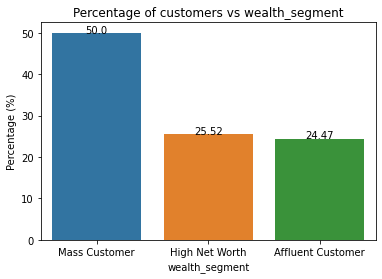

In [149]:
# Create bar plot
visual = sns.barplot(x="wealth_segment", y="customer_id", data=data_wealthsegment )

for index, row in data_wealthsegment.iterrows():
    visual.text(row.name,row.customer_id, round(row.customer_id,2), color='black', ha="center")
plt.title('Percentage of customers vs wealth_segment')
plt.ylabel('Percentage (%)')

- 50% of customers fall in the category "Mass Customers" and the other half is almost equally divided by 2 categories "High net worth" and "Affluent customers"

Text(0, 0.5, 'Count')

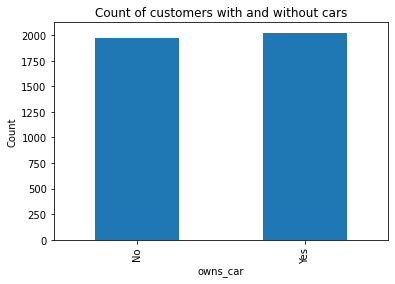

In [150]:
# Count of customers with and without cars
CustomerDemographic.groupby(['owns_car'])['customer_id'].count().plot.bar()
plt.title("Count of customers with and without cars")
plt.ylabel("Count")

Text(0.5, 1.0, 'Percentage of customers with and without cars')

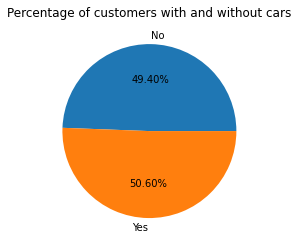

In [151]:
# Percentage of customers with and without cars
owns_car_count=pd.DataFrame(CustomerDemographic.groupby(['owns_car'])['customer_id'].count()/len(CustomerDemographic)).reset_index()
plt.pie(owns_car_count['customer_id'],labels=owns_car_count['owns_car'],autopct='%1.2f%%')
plt.title("Percentage of customers with and without cars")

- Almost half of of the customers have car.

#**DATASET 2: CUSTOMER ADDRESSES**

In [152]:
CustomerAddress.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


## Data Quality Analysis

In [153]:
# Check number of rows and columns
CustomerAddress.shape

(3999, 6)

- Notice, this dataset only has 1 row less than the Dmographic Dataset. 1 customer did not have address recorded.

In [154]:
# Data types
CustomerAddress.dtypes

customer_id            int64
address               object
postcode               int64
state                 object
country               object
property_valuation     int64
dtype: object

**1. Check data accuracy**

In [155]:
# Check if customer_id values are all unique. Each customer should have only one unique customer_id
customerID_duplicated = CustomerAddress['customer_id'].duplicated().any()
customerID_duplicated

False

In [156]:
# Check if address are duplicated
address_duplicated = CustomerAddress['address'].duplicated().sum()
address_duplicated

3

- There are 3 customers from the same household

In [157]:
# Check if postcode are duplicated
postcode_duplicated = CustomerAddress['postcode'].duplicated().sum()
postcode_duplicated

3126

In [158]:
# show all rows with duplicated postcode
CustomerAddress[CustomerAddress.duplicated(['postcode'], keep=False)]

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9
...,...,...,...,...,...,...
3994,3999,1482 Hauk Trail,3064,VIC,Australia,3
3995,4000,57042 Village Green Point,4511,QLD,Australia,6
3996,4001,87 Crescent Oaks Alley,2756,NSW,Australia,10
3997,4002,8194 Lien Street,4032,QLD,Australia,7


In [159]:
# Show example of 1 duplicated postcode with different addresses
CustomerAddress.loc[CustomerAddress['postcode'] == 2251]

,customer_id,address,postcode,state,country,property_valuation
340,345,08 Ronald Regan Plaza,2251,NSW,Australia,9
1191,1196,894 Maple Wood Drive,2251,NSW,Australia,10
1492,1497,7049 Sutteridge Lane,2251,NSW,Australia,8
1576,1581,45314 Pepper Wood Junction,2251,NSW,Australia,6
1799,1804,3 Mallard Center,2251,NSW,Australia,8
3998,4003,320 Acker Drive,2251,NSW,Australia,7


- There are 3126 rows with duplicated postcode. This makes sense because a postcode is used to identify a pre-defined area, not a single household.

**2. Check data completeness**

In [160]:
# Count number of empty rows and the percentage of empty rows for each column
empty_rows_count = CustomerAddress.isnull().sum()
empty_rows_perc = empty_rows_count/len(CustomerAddress)*100

null_values_perc = pd.DataFrame(empty_rows_count, columns=['Null_rows_count'])
null_values_perc['Null_rows_percentage'] = empty_rows_perc
null_values_perc


,Null_rows_count,Null_rows_percentage
customer_id,0,0.0
address,0,0.0
postcode,0,0.0
state,0,0.0
country,0,0.0
property_valuation,0,0.0


- This dataset is clean and there are no missing values.

**3. Check data consistency**

In [161]:
# Check unique values for state column
CustomerAddress['state'].unique()

array(['New South Wales', 'QLD', 'VIC', 'NSW', 'Victoria'], dtype=object)

In [162]:
# Check if addresses starts with a valid number. Addresses cannot start with 0
CustomerAddress.loc[CustomerAddress['address'].str.startswith('0', na=False)]

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
15,18,092 2nd Alley,2135,New South Wales,Australia,12
17,20,032 Bartelt Crossing,2444,New South Wales,Australia,8
25,30,02663 Buell Parkway,2519,New South Wales,Australia,11
...,...,...,...,...,...,...
3940,3945,093 Mallard Hill,4034,QLD,Australia,7
3965,3970,02 Fair Oaks Lane,3977,VIC,Australia,7
3967,3972,08 Dennis Crossing,3184,VIC,Australia,11
3971,3976,07 Morning Court,3805,VIC,Australia,7


- There are 399 addresses starts with 0 or have street number as 0. These need to be cleaned up.

**4. Check data currency**

- Customers address can be updated if there are any changes.

**5. Check data relevancy**

- Column country is irrelevant since all customers are in Australia, thus it does not add any differentiating factors to the analysis.

**6. Validate data**

In [163]:
# Summary statistics for columns with datatypes integer and float
CustomerAddress['property_valuation'].describe()

count    3999.000000
mean        7.514379
std         2.824663
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        12.000000
Name: property_valuation, dtype: float64

- Column property_valuation has values within acceptable min and max values.

**7. Check for duplicates**

In [164]:
# Count number of duplicates for each column
CustomerAddress.duplicated().sum()

0

## Data Cleaning

**Fill in nan values as suggested above**

- No missing values to be filled.

In [165]:
CustomerAddress.isnull().sum()

customer_id           0
address               0
postcode              0
state                 0
country               0
property_valuation    0
dtype: int64

**Replace misstyped data as suggested above**

In [166]:
# Create new column "new_address that strip out the leading '0' for rows that start with '0'
CustomerAddress['new_address'] = CustomerAddress['address'].apply(lambda x : x[1:] if x.startswith("0") else x)
CustomerAddress

,customer_id,address,postcode,state,country,property_valuation,new_address
0,1,060 Morning Avenue,2016,New South Wales,Australia,10,60 Morning Avenue
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10,6 Meadow Vale Court
2,4,0 Holy Cross Court,4211,QLD,Australia,9,Holy Cross Court
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4,17979 Del Mar Point
4,6,9 Oakridge Court,3216,VIC,Australia,9,9 Oakridge Court
...,...,...,...,...,...,...,...
3994,3999,1482 Hauk Trail,3064,VIC,Australia,3,1482 Hauk Trail
3995,4000,57042 Village Green Point,4511,QLD,Australia,6,57042 Village Green Point
3996,4001,87 Crescent Oaks Alley,2756,NSW,Australia,10,87 Crescent Oaks Alley
3997,4002,8194 Lien Street,4032,QLD,Australia,7,8194 Lien Street


In [167]:
# Show rows that does not have a street number, only street names
CustomerAddress[~CustomerAddress['new_address'].str.startswith(('1', '2', '3', '4', '5', '6', '7', '8', '9'))]

,customer_id,address,postcode,state,country,property_valuation,new_address
2,4,0 Holy Cross Court,4211,QLD,Australia,9,Holy Cross Court
107,112,0 David Terrace,3204,VIC,Australia,11,David Terrace
122,127,0 Pearson Crossing,4405,QLD,Australia,1,Pearson Crossing
133,138,0 Golden Leaf Crossing,2033,New South Wales,Australia,9,Golden Leaf Crossing
152,157,0 Hazelcrest Road,3025,VIC,Australia,8,Hazelcrest Road
...,...,...,...,...,...,...,...
3843,3848,0056 Corry Center,2220,NSW,Australia,11,056 Corry Center
3859,3864,0 Arapahoe Court,4305,QLD,Australia,3,Arapahoe Court
3904,3909,0 Darwin Junction,2747,NSW,Australia,9,Darwin Junction
3917,3922,0 Southridge Drive,4311,QLD,Australia,1,Southridge Drive


- There are still 121 addresses that do not have street number, only street name. We will still keep these rows as we can still perform analysis based on postcode and state.

**Drop irrelavant columns**

In [168]:
# drop column 'country' as all custoemrs are in Autralia and do not add value to the analysis
CustomerAddress.drop('country', axis='columns', inplace=True)

In [169]:
# Drop the old 'address' column and keep the 'new_address' column
CustomerAddress = CustomerAddress[['customer_id', 'new_address', 'postcode', 'state', 'property_valuation']]

In [170]:
CustomerAddress.to_csv("CustomerAddress.csv")

## Preliminary Analysis

In [171]:
CustomerAddress.head()

,customer_id,new_address,postcode,state,property_valuation
0,1,60 Morning Avenue,2016,New South Wales,10
1,2,6 Meadow Vale Court,2153,New South Wales,10
2,4,Holy Cross Court,4211,QLD,9
3,5,17979 Del Mar Point,2448,New South Wales,4
4,6,9 Oakridge Court,3216,VIC,9


In [172]:
# Calculate percentage of customers by job_industry_category
data_property_valuation = pd.DataFrame((CustomerAddress.groupby(['property_valuation'])['customer_id'].count())/len(CustomerAddress)*100)
data_property_valuation = data_property_valuation.reset_index()
data_property_valuation

,property_valuation,customer_id
0,1,3.850963
1,2,3.575894
2,3,4.651163
3,4,5.351338
4,5,5.626407
5,6,5.951488
6,7,12.328082
7,8,16.154039
8,9,16.179045
9,10,14.428607


Text(0, 0.5, 'Percentage (%)')

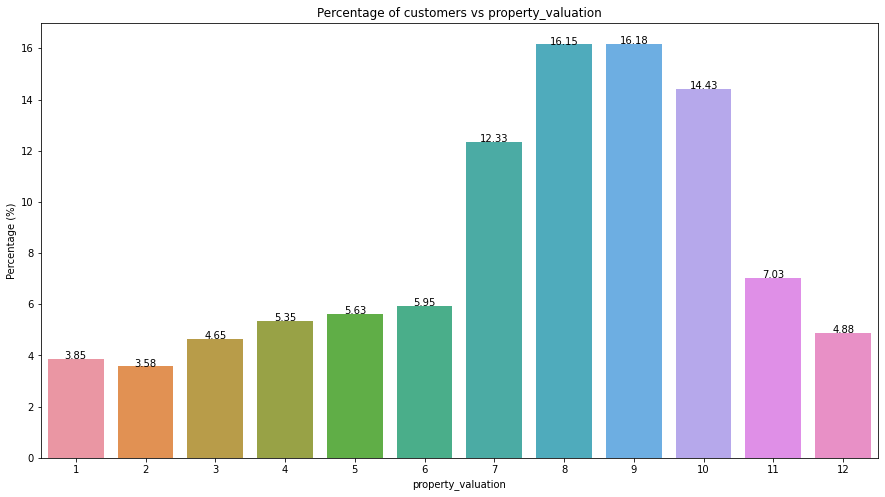

In [173]:
# Create bar plot
plt.figure(figsize=(15,8))
visual = sns.barplot(x="property_valuation", y="customer_id", data=data_property_valuation )

for index, row in data_property_valuation.iterrows():
    visual.text(row.name,row.customer_id, round(row.customer_id,2), color='black', ha="center")
plt.title('Percentage of customers vs property_valuation')
plt.ylabel('Percentage (%)')

- The majority of customers have property valuations between 7-10

#**DATASET 3: TRANSACTIONS**

In [174]:
Transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


## Data Quality Analysis

In [175]:
# Check number of rows and columns
Transactions.shape

(20000, 13)

- Notice, this dataset only has 20,000 transactions. This means customers puchase several items.

In [176]:
# Data types
Transactions.dtypes

transaction_id                      int64
product_id                          int64
customer_id                         int64
transaction_date           datetime64[ns]
online_order                      float64
order_status                       object
brand                              object
product_line                       object
product_class                      object
product_size                       object
list_price                        float64
standard_cost                     float64
product_first_sold_date           float64
dtype: object

- Notice, product_first_sold_date column is as float and it represents the number of days passed Jan 01 1970. This column will be converted to date_time.

**1. Check data accuracy**

In [177]:
# Check if transaction_id values are all unique
Transactions_duplicated = Transactions['transaction_id'].duplicated().any()
Transactions_duplicated

False

**2. Check data completeness**

In [178]:
# Count number of empty rows and the percentage of empty rows for each column
empty_rows_count = Transactions.isnull().sum()
empty_rows_perc = empty_rows_count/len(Transactions)*100

null_values_perc = pd.DataFrame(empty_rows_count, columns=['Null_rows_count'])
null_values_perc['Null_rows_percentage'] = empty_rows_perc
null_values_perc


,Null_rows_count,Null_rows_percentage
transaction_id,0,0.000
product_id,0,0.000
customer_id,0,0.000
transaction_date,0,0.000
online_order,360,1.800
order_status,0,0.000
brand,197,0.985
product_line,197,0.985
product_class,197,0.985
product_size,197,0.985


In [179]:
# Show rows without online_order values
Transactions[Transactions.online_order.isnull()]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
97,98,49,333,2017-06-23,NaN,Approved,Trek Bicycles,Road,medium,medium,533.51,400.13,37823.0
166,167,90,3177,2017-04-26,NaN,Approved,Norco Bicycles,Standard,low,medium,363.01,290.41,38482.0
169,170,6,404,2017-10-16,NaN,Approved,OHM Cycles,Standard,high,medium,227.88,136.73,37838.0
250,251,63,1967,2017-04-11,NaN,Approved,Solex,Standard,medium,medium,1483.20,99.59,42145.0
300,301,78,2530,2017-03-24,NaN,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,35455.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19514,19515,51,690,2017-01-22,NaN,Approved,OHM Cycles,Standard,high,medium,2005.66,1203.40,37823.0
19573,19574,18,1735,2017-01-15,NaN,Approved,Solex,Standard,medium,medium,575.27,431.45,41345.0
19580,19581,49,1933,2017-10-12,NaN,Approved,Trek Bicycles,Road,medium,medium,533.51,400.13,41064.0
19635,19636,98,1389,2017-07-26,NaN,Approved,Trek Bicycles,Standard,high,medium,358.39,215.03,38002.0


In [180]:
# Show rows without brand values
Transactions[Transactions.brand.isnull()]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
136,137,0,431,2017-09-23,0.0,Approved,NaN,NaN,NaN,NaN,1942.61,NaN,NaN
159,160,0,3300,2017-08-27,0.0,Approved,NaN,NaN,NaN,NaN,1656.86,NaN,NaN
366,367,0,1614,2017-03-10,0.0,Approved,NaN,NaN,NaN,NaN,850.89,NaN,NaN
406,407,0,2559,2017-06-14,1.0,Approved,NaN,NaN,NaN,NaN,710.59,NaN,NaN
676,677,0,2609,2017-07-02,0.0,Approved,NaN,NaN,NaN,NaN,1972.01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19340,19341,0,443,2017-12-26,1.0,Approved,NaN,NaN,NaN,NaN,744.54,NaN,NaN
19383,19384,0,2407,2017-06-11,0.0,Approved,NaN,NaN,NaN,NaN,1098.18,NaN,NaN
19793,19794,0,2860,2017-01-13,0.0,Approved,NaN,NaN,NaN,NaN,868.56,NaN,NaN
19859,19860,0,2468,2017-06-24,1.0,Approved,NaN,NaN,NaN,NaN,1497.43,NaN,NaN


- There are 360 rows (1.8%) without online_order indicator. Since they only make up a small fraction of the data. We can drop these rows.
- There are also 197 rows without any product information. These rows have 6 columns with missing values and thus do not add much values to the analysis and ML model. They will also be dropped.

**3. Check data consistency, misstyped values**

In [181]:
Transactions['product_id'].unique()

array([  2,   3,  37,  88,  78,  25,  22,  15,  67,  12,   5,  61,  35,
        16,  79,  33,  54,  27,  82,  89,  64,  19,  72,  91,   1,  99,
         0,  92,  14,  44,  76,  46,  55,  66,  81,  86,  32,  77,  96,
         6,  47,  94,  93,  60,  28,   4,  38,  56,  58,  50,  80,  87,
        84,  21,  31,  62,  17,  73,  45,  49,  95,  18,  70,  26,  39,
        36,  98,  75,  42,  20,  24,  53,  65,  29,  11,  10,   7,  41,
         9,  69,  90,  97, 100,  74,  71,  34,  57,  23,  51,  59,  63,
        40,   8,  13,  30,  48,  68,  83,  43,  52,  85])

In [182]:
Transactions['online_order'].unique()

array([ 0.,  1., nan])

In [183]:
Transactions['order_status'].unique()

array(['Approved', 'Cancelled'], dtype=object)

In [184]:
Transactions['brand'].unique()

array(['Solex', 'Trek Bicycles', 'OHM Cycles', 'Norco Bicycles',
       'Giant Bicycles', 'WeareA2B', nan], dtype=object)

In [185]:
Transactions['product_line'].unique()

array(['Standard', 'Road', 'Mountain', 'Touring', nan], dtype=object)

In [186]:
Transactions['product_class'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [187]:
Transactions['product_size'].unique()

array(['medium', 'large', 'small', nan], dtype=object)

**4. Check data currency**

- Customers information can be updated if there are any changes.

**5. Check data relevancy**

- All columns are relevant.

**6. Validate data**

In [188]:
# Summary statistics for columns with datatypes integer and float
Transactions.describe(include=['float64'])

,online_order,list_price,standard_cost,product_first_sold_date
count,19640.000000,20000.000000,19803.000000,19803.000000
mean,0.500458,1107.829449,556.046951,38199.776549
std,0.500013,582.825242,405.955660,2875.201110
min,0.000000,12.010000,7.210000,33259.000000
25%,0.000000,575.270000,215.140000,35667.000000
50%,1.000000,1163.890000,507.580000,38216.000000
75%,1.000000,1635.300000,795.100000,40672.000000
max,1.000000,2091.470000,1759.850000,42710.000000


- All numerical columns have values within acceptable min and max values.

**7. Check for duplicates**

In [189]:
# Count number of duplicates for each column
Transactions.duplicated().sum()

0

## Data Cleaning

**Change column product_first_sold_date dtype to date_time**

In [190]:
# Convert number of days into date_time
Transactions['product_first_sold_date'] = pd.to_datetime(Transactions['product_first_sold_date'], unit='D',
                   origin=pd.Timestamp('1970-01-01'))

In [191]:
Transactions.loc[Transactions['product_first_sold_date'] >= datetime.now()]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2082-12-04
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2084-03-04
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,2069-07-21
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,2068-12-17
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,2085-08-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,51,1018,2017-06-24,1.0,Approved,OHM Cycles,Standard,high,medium,2005.66,1203.40,2073-07-22
19996,19997,41,127,2017-11-09,1.0,Approved,Solex,Road,medium,medium,416.98,312.74,2067-05-12
19997,19998,87,2284,2017-04-14,1.0,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,2080-08-21
19998,19999,6,2764,2017-07-03,0.0,Approved,OHM Cycles,Standard,high,medium,227.88,136.73,2074-08-19


- Notice, after converting product_first_sold_date to datetime, it appears that most of the days in the list are in the future of the current time of the analysis. This is contradicting and this column can be dropped.

**Drop rows with nan values**

In [192]:
# Drop nan rows
Transactions.dropna(how='any', inplace=True)

In [193]:
# Check
Transactions.isnull().sum()

transaction_id             0
product_id                 0
customer_id                0
transaction_date           0
online_order               0
order_status               0
brand                      0
product_line               0
product_class              0
product_size               0
list_price                 0
standard_cost              0
product_first_sold_date    0
dtype: int64

In [194]:
# Drop product_first_sold_date column
Transactions.drop('product_first_sold_date', axis='columns', inplace=True)

**Replace misstyped data as suggested above**

- No columns have misstyped data.

**Drop irrelavant columns**

- No irrelavant columns.

In [195]:
# Save to csv
Transactions.to_csv('Transactions.csv')

## Preliminary Analysis

In [196]:
Transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48


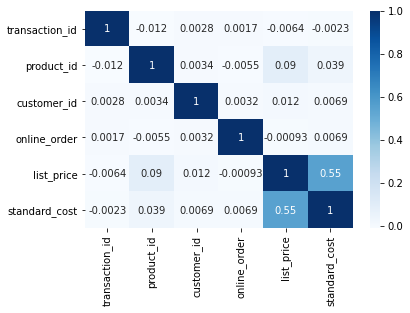

In [197]:
# Correlation matrix
corr = Transactions.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

- There are no major correlations except a positive correlation between list_price and standard_cost.

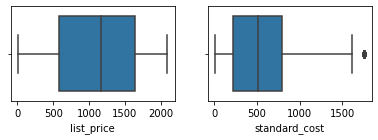

In [198]:
# Check for outliers
i=1
columns = ['list_price', 'standard_cost']
plt.figure(figsize=(10,8))
for j in columns:
    plt.subplot(4,3,i)
    sns.boxplot(data=Transactions,x=Transactions[j])
    i+=1

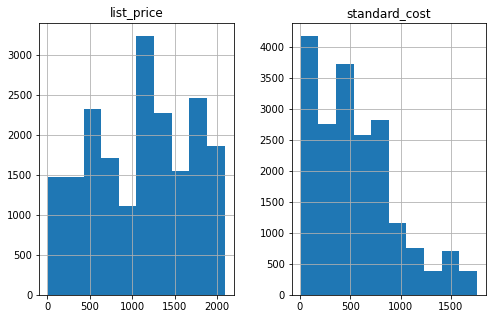

In [199]:
data = Transactions[['list_price', 'standard_cost']]
data.hist(figsize=(8,5))
plt.show()

- No variables follow a normal distribution.

In [200]:
# Calculate percentage of transactions by brand
data_brand = pd.DataFrame((Transactions.groupby(['brand'])['transaction_id'].count())/len(Transactions)*100)
data_brand = data_brand.sort_values(by=['transaction_id'], ascending=False)
data_brand = data_brand.reset_index()
data_brand

,brand,transaction_id
0,Solex,21.439959
1,WeareA2B,16.688095
2,Giant Bicycles,16.682952
3,OHM Cycles,15.392132
4,Trek Bicycles,15.073284
5,Norco Bicycles,14.723579


Text(0, 0.5, 'Percentage (%)')

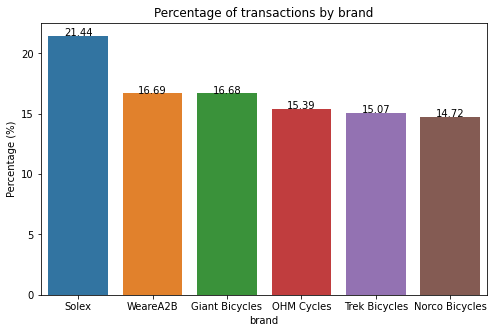

In [201]:
# Create bar plot
plt.figure(figsize=(8,5))
visual = sns.barplot(x="brand", y="transaction_id", data=data_brand )

for index, row in data_brand.iterrows():
    visual.text(row.name,row.transaction_id, round(row.transaction_id,2), color='black', ha="center")
plt.title('Percentage of transactions by brand')
plt.ylabel('Percentage (%)')

- Most of the brands are equally popular.

In [202]:
# Calculate percentage of transactions by product_line
data_line = pd.DataFrame((Transactions.groupby(['product_line'])['transaction_id'].count())/len(Transactions)*100)
data_line = data_line.sort_values(by=['transaction_id'], ascending=False)
data_line = data_line.reset_index()
data_line

,product_line,transaction_id
0,Standard,71.586526
1,Road,20.025714
2,Touring,6.238107
3,Mountain,2.149653


Text(0, 0.5, 'Percentage (%)')

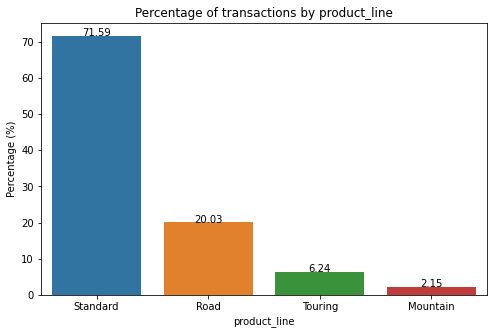

In [203]:
# Create bar plot
plt.figure(figsize=(8,5))
visual = sns.barplot(x="product_line", y="transaction_id", data=data_line )

for index, row in data_line.iterrows():
    visual.text(row.name,row.transaction_id, round(row.transaction_id,2), color='black', ha="center")
plt.title('Percentage of transactions by product_line')
plt.ylabel('Percentage (%)')

- Product line 'standard' is purchased most of the time, followed by 'road', ' touring', and 'mountain' products.

In [204]:
# Calculate percentage of transactions by product_class
data_class = pd.DataFrame((Transactions.groupby(['product_class'])['transaction_id'].count())/len(Transactions)*100)
data_class = data_class.sort_values(by=['transaction_id'], ascending=False)
data_class = data_class.reset_index()
data_class

,product_class,transaction_id
0,medium,69.874004
1,high,15.181281
2,low,14.944716


Text(0, 0.5, 'Percentage (%)')

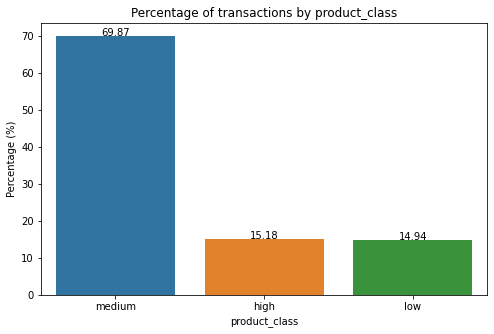

In [205]:
# Create bar plot
plt.figure(figsize=(8,5))
visual = sns.barplot(x="product_class", y="transaction_id", data=data_class )

for index, row in data_class.iterrows():
    visual.text(row.name,row.transaction_id, round(row.transaction_id,2), color='black', ha="center")
plt.title('Percentage of transactions by product_class')
plt.ylabel('Percentage (%)')

- Products with medium class is the most purchased, followed by high class and then low class.

In [206]:
# Calculate percentage of transactions by product_size
data_size = pd.DataFrame((Transactions.groupby(['product_size'])['transaction_id'].count())/len(Transactions)*100)
data_size = data_size.sort_values(by=['transaction_id'], ascending=False)
data_size = data_size.reset_index()
data_size

,product_size,transaction_id
0,medium,65.656981
1,large,20.056570
2,small,14.286449


Text(0, 0.5, 'Percentage (%)')

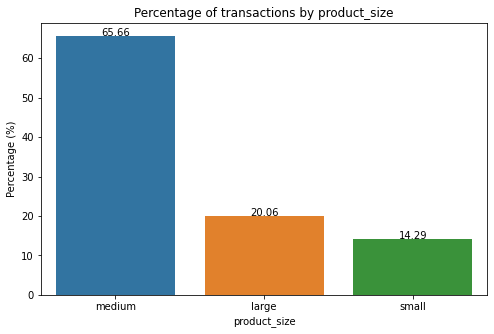

In [207]:
# Create bar plot
plt.figure(figsize=(8,5))
visual = sns.barplot(x="product_size", y="transaction_id", data=data_size )

for index, row in data_size.iterrows():
    visual.text(row.name,row.transaction_id, round(row.transaction_id,2), color='black', ha="center")
plt.title('Percentage of transactions by product_size')
plt.ylabel('Percentage (%)')

- Products with medium size is the most purchased, followed by large size and then small size.

**END OF DATA EXPLORATION AND CLEANING**

**NEXT STEP: BUILD POWER BI DASHBOARD**